In [1]:
from chap4 import GPTModel, generate_text_simple
import torch
import tiktoken

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,    #1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,       #2
    "qkv_bias": False
}
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='tanh')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): 

In [2]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)    #1
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)                #2
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Lifetime additionalumsy defeating Increasing Lyon shockSource Gearretched


# Not needed for train

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

In [ ]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

In [ ]:
with torch.no_grad():     #1
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)     #2
print(probas.shape)

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

In [ ]:
targets[text_idx]

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

In [ ]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

In [ ]:
neg_avg_log_probas = -avg_log_probas
print(neg_avg_log_probas)

In [ ]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

# Needed for train

In [3]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [4]:
file_path = "The_Mathematical_Principles_of_Natural_Philosophy_1729.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data_ext = file.read()

In [5]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: {:,}".format(total_characters))
print("Tokens: {:,}".format(total_tokens))

Characters: 20,479
Tokens: 5,145


In [6]:
total_characters = len(text_data_ext)
total_tokens = len(tokenizer.encode(text_data_ext))
print("Characters: {:,}".format(total_characters))
print("Tokens: {:,}".format(total_tokens))

Characters: 1,267,243
Tokens: 305,119


In [7]:
train_ratio = 0.80
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

train_ratio = 0.70
split_idx = int(train_ratio * len(text_data_ext))
train_data += text_data_ext[:split_idx]
val_data += text_data_ext[split_idx:]

In [8]:
from chap2 import create_dataloader_v1

batch_size = 2

train_loader = create_dataloader_v1(
    train_data,
    batch_size=batch_size,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=batch_size,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [9]:
print("Train loader size: {:,}".format(len(val_loader)))

print("Validation loader size: {:,}".format(len(val_loader)))

Train loader size: 179
Validation loader size: 179


In [10]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)         #1
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [11]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)     #1
    else:
        num_batches = min(num_batches, len(data_loader))   #2
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()    #3
        else:
            break
    return total_loss / num_batches    #4

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)   #1
# with torch.no_grad():                                        #2
#     train_loss = calc_loss_loader(train_loader, model, device)    #3
#     val_loss = calc_loss_loader(val_loader, model, device)
# print("Training loss:", train_loss)
# print("Validation loss:", val_loss)

In [13]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  #1
    with torch.no_grad():                              #2
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))      #1
    model.train()


def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []    #1
    tokens_seen, global_step = 0, -1

    try:
        for epoch in range(num_epochs):    #2
            model.train()
            for input_batch, target_batch in train_loader:
                optimizer.zero_grad()   #3
                loss = calc_loss_batch(
                    input_batch, target_batch, model, device
                )
                loss.backward()                     #4
                optimizer.step()                    #5
                tokens_seen += input_batch.numel()
                global_step += 1
    
                if global_step % eval_freq == 0:    #6
                    train_loss, val_loss = evaluate_model(
                        model, train_loader, val_loader, device, eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(f"Ep {epoch+1} (Step {global_step:06d}): "
                          f"Train loss {train_loss:.3f}, "
                          f"Val loss {val_loss:.3f}"
                    )
    
            generate_and_print_sample(                      #7
                model, tokenizer, device, start_context
            )
    except KeyboardInterrupt:
        print('Process interrupted.')
    return train_losses, val_losses, track_tokens_seen

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
     model.parameters(),           #1
    lr=0.0004, weight_decay=0.1
)

In [15]:
num_epochs = 100
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.360, Val loss 9.830
Ep 1 (Step 000005): Train loss 8.263, Val loss 8.429
Ep 1 (Step 000010): Train loss 7.165, Val loss 7.602
Ep 1 (Step 000015): Train loss 6.781, Val loss 7.203
Ep 1 (Step 000020): Train loss 6.539, Val loss 7.016
Ep 1 (Step 000025): Train loss 6.516, Val loss 7.110
Ep 1 (Step 000030): Train loss 6.428, Val loss 6.831
Ep 1 (Step 000035): Train loss 6.033, Val loss 6.674
Ep 1 (Step 000040): Train loss 5.780, Val loss 6.614
Ep 1 (Step 000045): Train loss 6.137, Val loss 6.619
Ep 1 (Step 000050): Train loss 5.780, Val loss 6.655
Ep 1 (Step 000055): Train loss 5.851, Val loss 6.507
Ep 1 (Step 000060): Train loss 5.735, Val loss 6.470
Ep 1 (Step 000065): Train loss 5.602, Val loss 6.423
Ep 1 (Step 000070): Train loss 5.649, Val loss 6.378
Ep 1 (Step 000075): Train loss 5.780, Val loss 6.382
Ep 1 (Step 000080): Train loss 5.518, Val loss 6.364
Ep 1 (Step 000085): Train loss 5.532, Val loss 6.426
Ep 1 (Step 000090): Train loss 5.902, Val loss

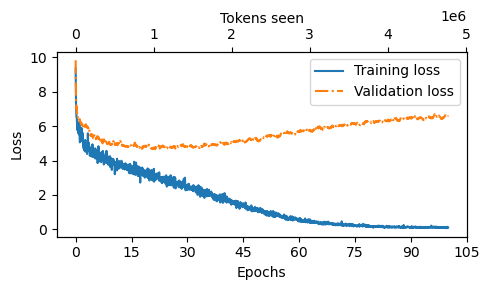

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                   #1
    ax2.plot(tokens_seen, train_losses, alpha=0)     #2
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [18]:
min(val_losses)

4.659332132339477

In [24]:
int(len(val_losses)*0.20)

372

In [25]:
torch.tensor(sorted(val_losses)[:372]).mean()

tensor(4.7983)